Neural UDE on Synthetic Data

In [ ]:

import os
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint as torch_odeint 
from scipy.integrate import odeint as scipy_odeint 

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


LEARNING_RATE = 1e-2
NUM_EPOCHS = 3000 
HIDDEN_DIM_NN = 32
ODE_SOLVER = 'dopri5' 
PRINT_EVERY = 100
WEIGHT_DECAY = 1e-6


TRUE_ALPHA = 1.5
TRUE_BETA = 1.0
TRUE_GAMMA = 2.0
TRUE_DELTA = 0.5
TRUE_PARAMS = [TRUE_ALPHA, TRUE_BETA, TRUE_GAMMA, TRUE_DELTA]
U0_SYNTH = [8.0, 3.0]
T_START = 0
T_END = 10
N_POINTS = 200


print("\n--- Generating Synthetic Lotka-Volterra Data ---")
def lotka_volterra(y, t, alpha, beta, gamma, delta):
    prey, predator = y
    d_prey = alpha * prey - beta * prey * predator
    d_predator = delta * prey * predator - gamma * predator
    return [d_prey, d_predator]

t_synth_np = np.linspace(T_START, T_END, N_POINTS).astype(np.float32)
synth_solution = scipy_odeint(
    lotka_volterra, U0_SYNTH, t_synth_np,
    args=(TRUE_ALPHA, TRUE_BETA, TRUE_GAMMA, TRUE_DELTA)
)

ADD_NOISE = True 
if ADD_NOISE:
    NOISE_LEVEL_SYNTH = 0.1 
    noise = np.random.normal(scale=NOISE_LEVEL_SYNTH, size=synth_solution.shape)
    synth_solution += noise
    synth_solution = np.maximum(0.01, synth_solution) 
    print(f"Added Gaussian noise with std dev {NOISE_LEVEL_SYNTH} to synthetic data.")


prey_synth_np = synth_solution[:, 0].astype(np.float32)
predator_synth_np = synth_solution[:, 1].astype(np.float32)
u_data_np_full = np.stack([prey_synth_np, predator_synth_np], axis=1) 

print(f"Generated {N_POINTS} synthetic data points from t={T_START} to t={T_END}.")


print("\n--- Preparing and Splitting Data (80% Train, 20% Test) ---")


split_ratio = 0.8
split_idx = int(split_ratio * N_POINTS)
n_train = split_idx
n_test = N_POINTS - n_train

print(f"Splitting data: {n_train} training points, {n_test} test points.")


t_train_np = t_synth_np[:split_idx]
u_train_np = u_data_np_full[:split_idx, :]
t_test_np = t_synth_np[split_idx:]
u_test_np = u_data_np_full[split_idx:, :]


t_train = torch.tensor(t_train_np, dtype=torch.float32).to(device)
u_train = torch.tensor(u_train_np, dtype=torch.float32).to(device)
t_test = torch.tensor(t_test_np, dtype=torch.float32).to(device)
u_test = torch.tensor(u_test_np, dtype=torch.float32).to(device)


t_data = torch.tensor(t_synth_np, dtype=torch.float32).to(device)


u0 = u_train[0].clone().detach().to(device) 

print("Data prepared:")
print(f"  Training time shape: {t_train.shape}")
print(f"  Training data shape: {u_train.shape}")
print(f"  Test time shape:     {t_test.shape}")
print(f"  Test data shape:     {u_test.shape}")
print(f"  Initial condition (u0): {u0.cpu().numpy()}")




class KnownDynamics(nn.Module):
    def __init__(self, initial_params=None):
        super().__init__()
        if initial_params is None:
             initial_params = torch.tensor([1.0, 0.1, 1.0, 0.1], dtype=torch.float32) 
        self.log_params = nn.Parameter(torch.log(initial_params + 1e-8))
    def forward(self, t, u): 
        if u.ndim == 1: u = u.unsqueeze(0)
        params = torch.exp(self.log_params)
        alpha, beta, gamma, delta = params[0], params[1], params[2], params[3]
        prey = u[:, 0]; predator = u[:, 1]
        d_prey = alpha * prey - beta * prey * predator
        d_predator = delta * prey * predator - gamma * predator
        du_dt = torch.stack([d_prey, d_predator], dim=1)
        
        return du_dt


class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=HIDDEN_DIM_NN, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('tanh'))
                if m.bias is not None: nn.init.zeros_(m.bias)
    def forward(self, u): return self.net(u)


class UDEdynamics(nn.Module):
    def __init__(self, initial_known_params=None):
        super().__init__()
        self.known_model = KnownDynamics(initial_known_params).to(device)
        self.neural_net = NeuralNetwork().to(device)
    def forward(self, t, u):
        
        known_contribution = self.known_model(t, u)
        nn_contribution = self.neural_net(u)
        return known_contribution + nn_contribution


ude_func = UDEdynamics().to(device)
parameters = list(ude_func.parameters())
optimizer = optim.Adam(parameters, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()


print("\n--- Starting Training UDE on Synthetic Data (First 80%) ---")
losses = []
min_loss = float('inf')
best_model_state = None
best_epoch = 0


for epoch in range(1, NUM_EPOCHS + 1):
    ude_func.train()
    optimizer.zero_grad()

    
    
    
    u_pred_train = torch_odeint(ude_func, u0, t_train, method=ODE_SOLVER, atol=1e-6, rtol=1e-6).to(device)

    
    loss = loss_fn(u_pred_train, u_train)

    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % PRINT_EVERY == 0 or epoch == 1:
        print(f"Epoch {epoch}/{NUM_EPOCHS}, Training Loss: {loss.item():.6f}")

    if loss.item() < min_loss:
        min_loss = loss.item()
        best_model_state = ude_func.state_dict()
        best_epoch = epoch

print("--- Training Complete ---")
print(f"Final Training Loss: {losses[-1]:.6f}")
print(f"Best Training Loss Achieved: {min_loss:.6f} at epoch {best_epoch}")

if best_model_state:
    ude_func.load_state_dict(best_model_state)
    print("Loaded best model state for evaluation.")
else:
    print("Warning: No best model state saved. Evaluating with final parameters.")



Using device: cpu

--- Generating Synthetic Lotka-Volterra Data ---
Added Gaussian noise with std dev 0.1 to synthetic data.
Generated 200 synthetic data points from t=0 to t=10.

--- Preparing and Splitting Data (80% Train, 20% Test) ---
Splitting data: 160 training points, 40 test points.
Data prepared:
  Training time shape: torch.Size([160])
  Training data shape: torch.Size([160, 2])
  Test time shape:     torch.Size([40])
  Test data shape:     torch.Size([40, 2])
  Initial condition (u0): [8.049671  2.9861736]

--- Starting Training UDE on Synthetic Data (First 80%) ---
Epoch 1/3000, Training Loss: 469.308594
Epoch 100/3000, Training Loss: 7.602838
Epoch 200/3000, Training Loss: 5.161454
Epoch 300/3000, Training Loss: 0.739524
Epoch 400/3000, Training Loss: 0.500542
Epoch 500/3000, Training Loss: 0.353993
Epoch 600/3000, Training Loss: 0.297157
Epoch 700/3000, Training Loss: 0.198752
Epoch 800/3000, Training Loss: 0.168478
Epoch 900/3000, Training Loss: 0.123435
Epoch 1000/3000,


--- Evaluating Model Fit (Train) and Forecast (Test) ---

--- Metrics Calculation ---

--- Training Set Metrics (Fit Performance) ---
  Metric       |   Prey    | Predator  |   Total   
----------------------------------------------------
  MSE          | 0.0127    | 0.0161    | 0.0144   
  RMSE         | 0.1126    | 0.1269    | 0.1200   
  MAE          | 0.0860    | 0.1013    | 0.0936   
  NRMSE (range)| 0.0129    | 0.0320    |    N/A    
  sMAPE (%)    | 3.37      | 12.55     |    N/A    
  R^2          | 0.9985    | 0.9896    | 0.9940   

--- Test Set Metrics (Forecast Performance) ---
  Metric       |   Prey    | Predator  |   Total   
----------------------------------------------------
  MSE          | 0.0170    | 0.0134    | 0.0152   
  RMSE         | 0.1303    | 0.1158    | 0.1233   
  MAE          | 0.1041    | 0.0940    | 0.0990   
  NRMSE (range)| 0.0190    | 0.0337    |    N/A    
  sMAPE (%)    | 5.47      | 5.90      |    N/A    
  R^2          | 0.9948    | 0.9909    | 

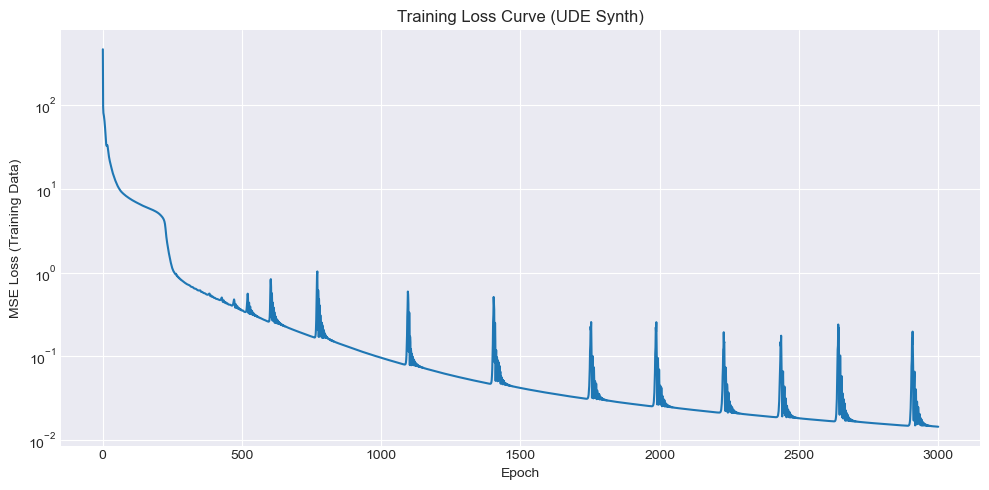

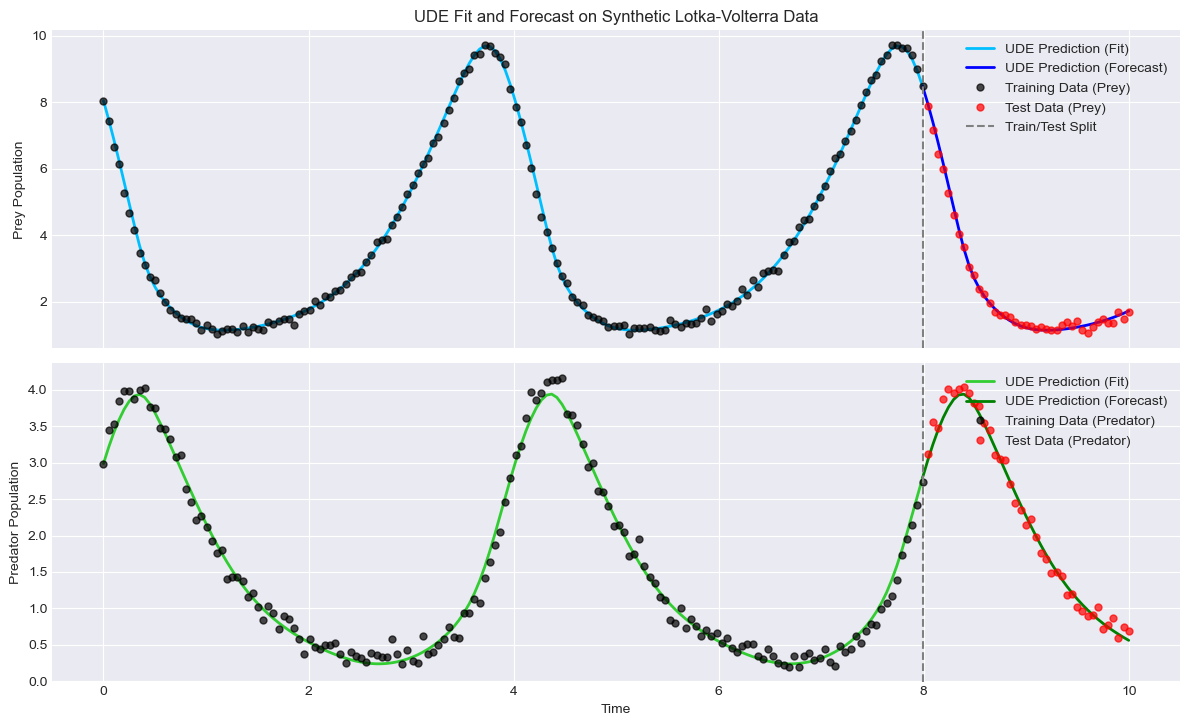

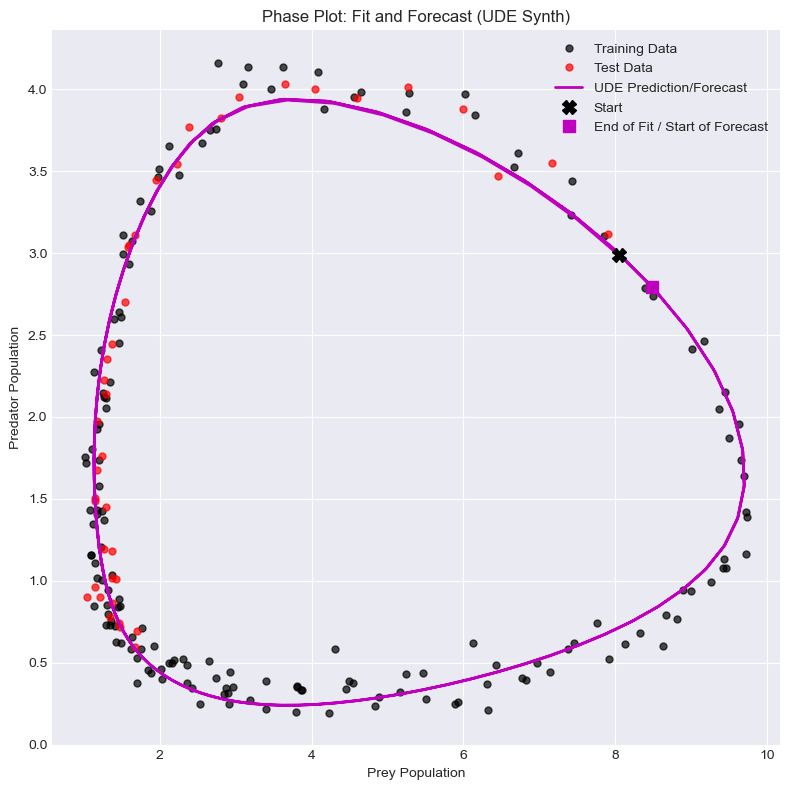

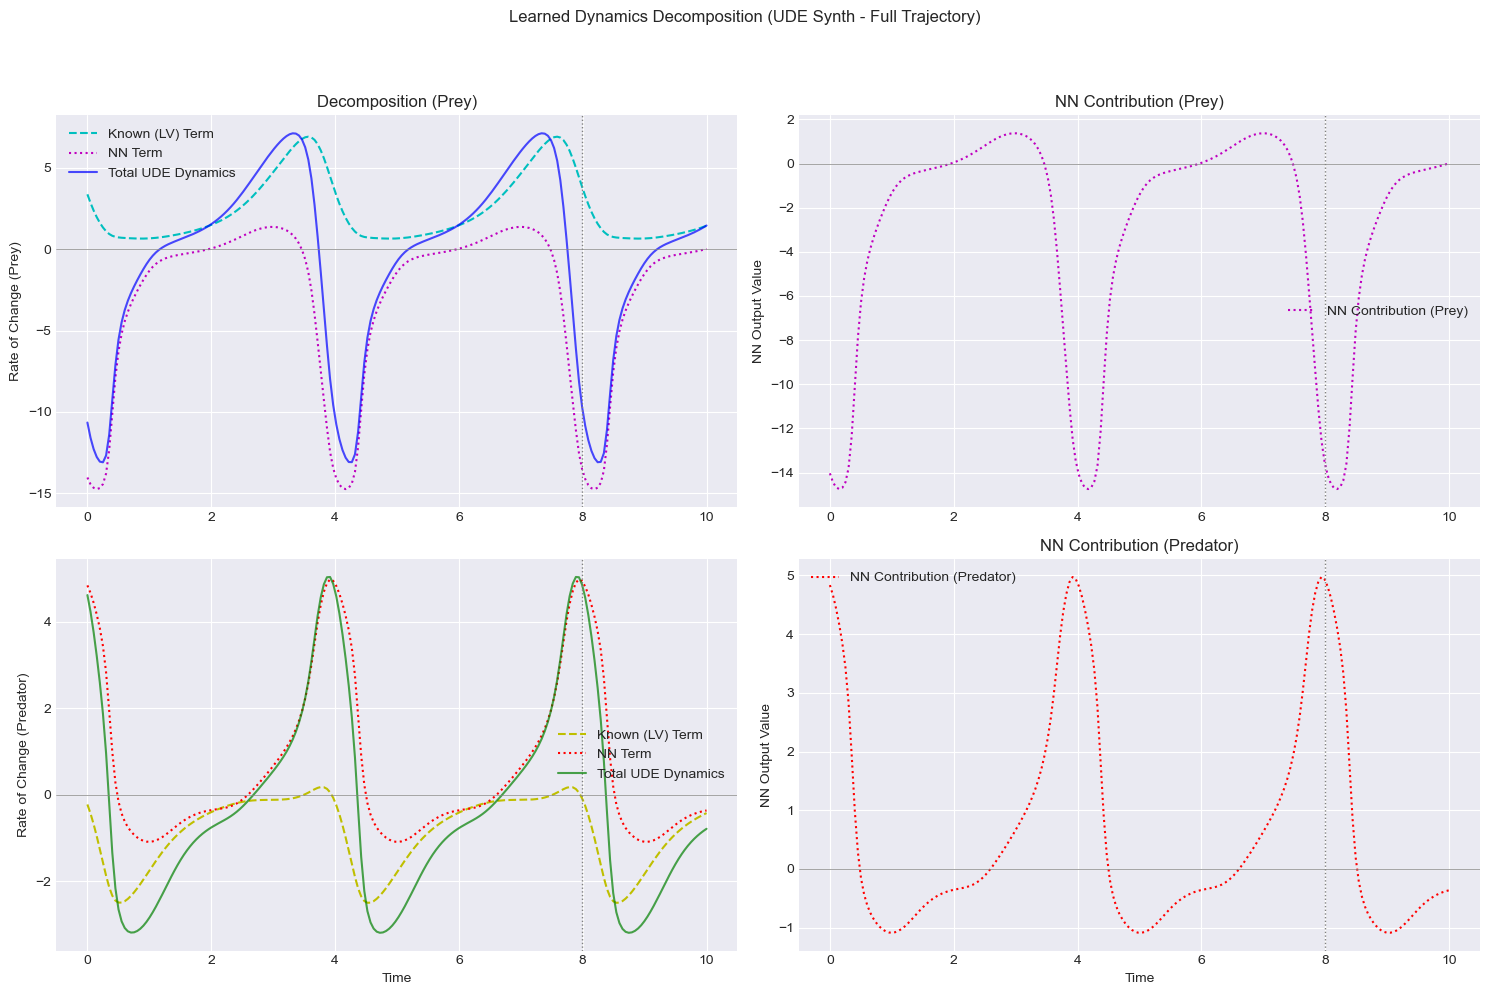


--- Script Finished ---


In [ ]:
def nrmse(y_true, y_pred):
    """Calculate Normalized Root Mean Squared Error (NRMSE) by range."""
    if y_true.ndim > 1 and y_true.shape[1] > 1: 
        return np.nan
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    data_range = np.max(y_true) - np.min(y_true)
    if data_range < 1e-8: 
        
        
        return np.nan if rmse > 1e-8 else 0.0
    return rmse / data_range

def smape(y_true, y_pred, epsilon=1e-8):
    """Calculate Symmetric Mean Absolute Percentage Error (sMAPE)."""
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0 
    
    ratio = numerator / (denominator + epsilon)
    return np.mean(ratio) * 100.0 



print("\n--- Evaluating Model Fit (Train) and Forecast (Test) ---")
ude_func.eval()
with torch.no_grad():
    
    u_pred_full = torch_odeint(ude_func, u0, t_data, method=ODE_SOLVER, atol=1e-7, rtol=1e-7).to(device)
    u_pred_full_np = u_pred_full.cpu().numpy() 

    
    u_pred_train_np = u_pred_full_np[:split_idx, :] 
    u_pred_test_np = u_pred_full_np[split_idx:, :]  

    
    print("\n--- Metrics Calculation ---")
    metrics_train = {}
    metrics_test = {}

    if not (np.isnan(u_pred_full_np).any() or np.isinf(u_pred_full_np).any()):
        
        u_train_prey = u_train_np[:, 0]
        u_train_predator = u_train_np[:, 1]
        u_test_prey = u_test_np[:, 0]
        u_test_predator = u_test_np[:, 1]

        
        u_pred_train_prey = u_pred_train_np[:, 0]
        u_pred_train_predator = u_pred_train_np[:, 1]
        u_pred_test_prey = u_pred_test_np[:, 0]
        u_pred_test_predator = u_pred_test_np[:, 1]

        
        
        metrics_train['MSE_prey'] = mean_squared_error(u_train_prey, u_pred_train_prey)
        metrics_train['MSE_predator'] = mean_squared_error(u_train_predator, u_pred_train_predator)
        metrics_train['MSE_total'] = mean_squared_error(u_train_np, u_pred_train_np) 
        
        metrics_train['RMSE_prey'] = np.sqrt(metrics_train['MSE_prey'])
        metrics_train['RMSE_predator'] = np.sqrt(metrics_train['MSE_predator'])
        metrics_train['RMSE_total'] = np.sqrt(metrics_train['MSE_total'])
        
        metrics_train['MAE_prey'] = mean_absolute_error(u_train_prey, u_pred_train_prey)
        metrics_train['MAE_predator'] = mean_absolute_error(u_train_predator, u_pred_train_predator)
        metrics_train['MAE_total'] = mean_absolute_error(u_train_np, u_pred_train_np) 
        
        metrics_train['NRMSE_prey'] = nrmse(u_train_prey, u_pred_train_prey)
        metrics_train['NRMSE_predator'] = nrmse(u_train_predator, u_pred_train_predator)
        
        metrics_train['sMAPE_prey'] = smape(u_train_prey, u_pred_train_prey)
        metrics_train['sMAPE_predator'] = smape(u_train_predator, u_pred_train_predator)
        
        metrics_train['R2_prey'] = r2_score(u_train_prey, u_pred_train_prey)
        metrics_train['R2_predator'] = r2_score(u_train_predator, u_pred_train_predator)
        metrics_train['R2_total'] = r2_score(u_train_np, u_pred_train_np) 

        
        
        metrics_test['MSE_prey'] = mean_squared_error(u_test_prey, u_pred_test_prey)
        metrics_test['MSE_predator'] = mean_squared_error(u_test_predator, u_pred_test_predator)
        metrics_test['MSE_total'] = mean_squared_error(u_test_np, u_pred_test_np)
        
        metrics_test['RMSE_prey'] = np.sqrt(metrics_test['MSE_prey'])
        metrics_test['RMSE_predator'] = np.sqrt(metrics_test['MSE_predator'])
        metrics_test['RMSE_total'] = np.sqrt(metrics_test['MSE_total'])
        
        metrics_test['MAE_prey'] = mean_absolute_error(u_test_prey, u_pred_test_prey)
        metrics_test['MAE_predator'] = mean_absolute_error(u_test_predator, u_pred_test_predator)
        metrics_test['MAE_total'] = mean_absolute_error(u_test_np, u_pred_test_np)
        
        metrics_test['NRMSE_prey'] = nrmse(u_test_prey, u_pred_test_prey)
        metrics_test['NRMSE_predator'] = nrmse(u_test_predator, u_pred_test_predator)
        
        metrics_test['sMAPE_prey'] = smape(u_test_prey, u_pred_test_prey)
        metrics_test['sMAPE_predator'] = smape(u_test_predator, u_pred_test_predator)
        
        metrics_test['R2_prey'] = r2_score(u_test_prey, u_pred_test_prey)
        metrics_test['R2_predator'] = r2_score(u_test_predator, u_pred_test_predator)
        metrics_test['R2_total'] = r2_score(u_test_np, u_pred_test_np)

        
        print("\n--- Training Set Metrics (Fit Performance) ---")
        print(f"  Metric       |   Prey    | Predator  |   Total   ")
        print(f"----------------------------------------------------")
        print(f"  MSE          | {metrics_train['MSE_prey']:<9.4f} | {metrics_train['MSE_predator']:<9.4f} | {metrics_train['MSE_total']:<9.4f}")
        print(f"  RMSE         | {metrics_train['RMSE_prey']:<9.4f} | {metrics_train['RMSE_predator']:<9.4f} | {metrics_train['RMSE_total']:<9.4f}")
        print(f"  MAE          | {metrics_train['MAE_prey']:<9.4f} | {metrics_train['MAE_predator']:<9.4f} | {metrics_train['MAE_total']:<9.4f}")
        print(f"  NRMSE (range)| {metrics_train['NRMSE_prey']:<9.4f} | {metrics_train['NRMSE_predator']:<9.4f} |    N/A    ")
        print(f"  sMAPE (%)    | {metrics_train['sMAPE_prey']:<9.2f} | {metrics_train['sMAPE_predator']:<9.2f} |    N/A    ")
        print(f"  R^2          | {metrics_train['R2_prey']:<9.4f} | {metrics_train['R2_predator']:<9.4f} | {metrics_train['R2_total']:<9.4f}")

        print("\n--- Test Set Metrics (Forecast Performance) ---")
        print(f"  Metric       |   Prey    | Predator  |   Total   ")
        print(f"----------------------------------------------------")
        print(f"  MSE          | {metrics_test['MSE_prey']:<9.4f} | {metrics_test['MSE_predator']:<9.4f} | {metrics_test['MSE_total']:<9.4f}")
        print(f"  RMSE         | {metrics_test['RMSE_prey']:<9.4f} | {metrics_test['RMSE_predator']:<9.4f} | {metrics_test['RMSE_total']:<9.4f}")
        print(f"  MAE          | {metrics_test['MAE_prey']:<9.4f} | {metrics_test['MAE_predator']:<9.4f} | {metrics_test['MAE_total']:<9.4f}")
        print(f"  NRMSE (range)| {metrics_test['NRMSE_prey']:<9.4f} | {metrics_test['NRMSE_predator']:<9.4f} |    N/A    ")
        print(f"  sMAPE (%)    | {metrics_test['sMAPE_prey']:<9.2f} | {metrics_test['sMAPE_predator']:<9.2f} |    N/A    ")
        print(f"  R^2          | {metrics_test['R2_prey']:<9.4f} | {metrics_test['R2_predator']:<9.4f} | {metrics_test['R2_total']:<9.4f}")
        print("-" * 52) 

    else:
        print("Error: Final predictions contain NaN or Inf. Cannot calculate metrics.")


    
    
    learned_params = torch.exp(ude_func.known_model.log_params).cpu().numpy()
    print("\nLearned Physical Parameters vs True Parameters:")
    print(f"                 True     Learned")
    print(f"  alpha:   {TRUE_ALPHA:<8.4f} {learned_params[0]:<8.4f}")
    print(f"  beta:    {TRUE_BETA:<8.4f} {learned_params[1]:<8.4f}")
    print(f"  gamma:   {TRUE_GAMMA:<8.4f} {learned_params[2]:<8.4f}")
    print(f"  delta:   {TRUE_DELTA:<8.4f} {learned_params[3]:<8.4f}")




print("\n--- Generating Plots (Including Forecast with Split Color) ---")
plt.style.use('seaborn-v0_8-darkgrid')
split_time = t_train_np[-1] 


plt.figure(1, figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (Training Data)")
plt.title("Training Loss Curve (UDE Synth)")
plt.yscale('log')
plt.tight_layout()


fig_ts, axs_ts = plt.subplots(2, 1, figsize=(12, 8), sharex=True)



fit_color_prey = 'deepskyblue'
forecast_color_prey = 'blue'
fit_color_predator = 'limegreen'
forecast_color_predator = 'green'



t_forecast_plot = np.concatenate(([t_train_np[-1]], t_test_np))

u_pred_forecast_plot_prey = np.concatenate(([u_pred_train_np[-1, 0]], u_pred_test_np[:, 0]))
u_pred_forecast_plot_predator = np.concatenate(([u_pred_train_np[-1, 1]], u_pred_test_np[:, 1]))



axs_ts[0].plot(t_train_np, u_pred_train_np[:, 0], color=fit_color_prey, linestyle='-', linewidth=2, label='UDE Prediction (Fit)')

axs_ts[0].plot(t_forecast_plot, u_pred_forecast_plot_prey, color=forecast_color_prey, linestyle='-', linewidth=2, label='UDE Prediction (Forecast)')


axs_ts[0].plot(t_train_np, u_train_np[:, 0], 'ko', markersize=5, alpha=0.7, label='Training Data (Prey)')
axs_ts[0].plot(t_test_np, u_test_np[:, 0], 'ro', markersize=5, alpha=0.7, label='Test Data (Prey)')
axs_ts[0].axvline(split_time, color='gray', linestyle='--', linewidth=1.5, label='Train/Test Split')
axs_ts[0].set_ylabel("Prey Population")
axs_ts[0].legend(loc='upper right')
axs_ts[0].set_title("UDE Fit and Forecast on Synthetic Lotka-Volterra Data")



axs_ts[1].plot(t_train_np, u_pred_train_np[:, 1], color=fit_color_predator, linestyle='-', linewidth=2, label='UDE Prediction (Fit)')

axs_ts[1].plot(t_forecast_plot, u_pred_forecast_plot_predator, color=forecast_color_predator, linestyle='-', linewidth=2, label='UDE Prediction (Forecast)')


axs_ts[1].plot(t_train_np, u_train_np[:, 1], 'ko', markersize=5, alpha=0.7, label='Training Data (Predator)')
axs_ts[1].plot(t_test_np, u_test_np[:, 1], 'ro', markersize=5, alpha=0.7, label='Test Data (Predator)')
axs_ts[1].axvline(split_time, color='gray', linestyle='--', linewidth=1.5) 
axs_ts[1].set_ylabel("Predator Population")
axs_ts[1].set_xlabel("Time")
axs_ts[1].legend(loc='upper right')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])



plt.figure(3, figsize=(8, 8))
plt.plot(u_train_np[:, 0], u_train_np[:, 1], 'ko', markersize=5, alpha=0.7, label='Training Data')
plt.plot(u_test_np[:, 0], u_test_np[:, 1], 'ro', markersize=5, alpha=0.7, label='Test Data')

plt.plot(u_pred_full_np[:, 0], u_pred_full_np[:, 1], 'm-', linewidth=2, label='UDE Prediction/Forecast')

plt.plot(u0[0].cpu(), u0[1].cpu(), 'kX', markersize=10, label='Start')
if not np.isnan(u_pred_train_np).any():
    plt.plot(u_pred_train_np[-1, 0], u_pred_train_np[-1, 1], 'ms', markersize=8, label='End of Fit / Start of Forecast')
plt.xlabel("Prey Population")
plt.ylabel("Predator Population")
plt.title("Phase Plot: Fit and Forecast (UDE Synth)")
plt.legend()
plt.grid(True)
plt.tight_layout()



print("\n--- Visualizing Learned Dynamics (Full Trajectory) ---")
with torch.no_grad():
    
    known_dyn_pred = torch.zeros_like(u_pred_full)
    nn_dyn_pred = torch.zeros_like(u_pred_full)
    
    for i in range(len(t_data)):
        u_i = u_pred_full[i].unsqueeze(0) 
        t_i = t_data[i]
        
        known_dyn_pred[i] = ude_func.known_model(t_i, u_i).squeeze(0)
        nn_dyn_pred[i] = ude_func.neural_net(u_i).squeeze(0)

    known_dyn_np = known_dyn_pred.cpu().numpy()
    nn_dyn_np = nn_dyn_pred.cpu().numpy()
    total_dyn_np = known_dyn_np + nn_dyn_np 


fig_decomp, axs_decomp = plt.subplots(2, 2, figsize=(15, 10))

axs_decomp[0, 0].plot(t_synth_np, known_dyn_np[:, 0], 'c--', label='Known (LV) Term')
axs_decomp[0, 0].plot(t_synth_np, nn_dyn_np[:, 0], 'm:', label='NN Term')
axs_decomp[0, 0].plot(t_synth_np, total_dyn_np[:, 0], 'b-', alpha=0.7, label='Total UDE Dynamics')
axs_decomp[0, 0].axvline(split_time, color='gray', linestyle=':', linewidth=1) 
axs_decomp[0, 0].set_ylabel("Rate of Change (Prey)")
axs_decomp[0, 0].legend(); axs_decomp[0, 0].set_title("Decomposition (Prey)")
axs_decomp[0, 0].axhline(0, color='gray', linestyle='-', linewidth=0.5); axs_decomp[0, 0].grid(True)

axs_decomp[1, 0].plot(t_synth_np, known_dyn_np[:, 1], 'y--', label='Known (LV) Term')
axs_decomp[1, 0].plot(t_synth_np, nn_dyn_np[:, 1], 'r:', label='NN Term')
axs_decomp[1, 0].plot(t_synth_np, total_dyn_np[:, 1], 'g-', alpha=0.7, label='Total UDE Dynamics')
axs_decomp[1, 0].axvline(split_time, color='gray', linestyle=':', linewidth=1)
axs_decomp[1, 0].set_ylabel("Rate of Change (Predator)"); axs_decomp[1, 0].set_xlabel("Time")
axs_decomp[1, 0].legend(); axs_decomp[1, 0].axhline(0, color='gray', linestyle='-', linewidth=0.5); axs_decomp[1, 0].grid(True)

axs_decomp[0, 1].plot(t_synth_np, nn_dyn_np[:, 0], 'm:', label='NN Contribution (Prey)')
axs_decomp[0, 1].axvline(split_time, color='gray', linestyle=':', linewidth=1)
axs_decomp[0, 1].set_ylabel("NN Output Value"); axs_decomp[0, 1].legend(); axs_decomp[0, 1].set_title("NN Contribution (Prey)")
axs_decomp[0, 1].axhline(0, color='gray', linestyle='-', linewidth=0.5); axs_decomp[0, 1].grid(True)

axs_decomp[1, 1].plot(t_synth_np, nn_dyn_np[:, 1], 'r:', label='NN Contribution (Predator)')
axs_decomp[1, 1].axvline(split_time, color='gray', linestyle=':', linewidth=1)
axs_decomp[1, 1].set_ylabel("NN Output Value"); axs_decomp[1, 1].set_xlabel("Time")
axs_decomp[1, 1].legend(); axs_decomp[1, 1].set_title("NN Contribution (Predator)")
axs_decomp[1, 1].axhline(0, color='gray', linestyle='-', linewidth=0.5); axs_decomp[1, 1].grid(True)

plt.suptitle("Learned Dynamics Decomposition (UDE Synth - Full Trajectory)", y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])


plt.show()

print("\n--- Script Finished ---")